<a id="ref1"></a>
<h2>COLLABORATIVE FILTERING</h2>
<h2>RECOMMENDATION SYSTEM WITH A RESTRICTED BOLTZMANN MACHINE</h2>

Kelompok:
1. Salsabila Ramadhina (11180910000111)
2. Muhammad Aqil Pratama (11180910000117)
3. Ahmad Malik Fajar (11180910000120)

Tahapan Experiment
1. Acquiring Data
2. Loading in the Data
3. The Restricted Boltzmann Machine model
4. Setting the Model's Parameter
5. Recommendation

<a id="ref1"></a>
<h2>Acquiring the Data</h2>

Sebelum mulai, kita harus download data yang akan kita gunakan di program kita nanti. Dataset yang akan kita gunakan sudah disediakan oleh GroupLens yang berisi film, users, dan rating film dari setiap user.

Setelah download data, kita akan meng-extract dataset ke direktori di laptop kita yang mudah untuk diakses.

In [1]:
import zipfile
import wget

In [2]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
print('unziping ...')
filename = wget.download(url)

unziping ...
100% [..........................................................................] 5917549 / 5917549

Setelah kita punya dataset, langkah selanjutnya adalah kita harus import library yang dibutuhkan. Kita akan menggunakan Tensorflow dan Numpy terhadap model dan inisialisasi RBM dan Pandas untuk dataset.

In [3]:
#Import library Tensorflow, digunakan pada membuat model untuk machine learning
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#Import library numpy, digunakan untuk memanggil fungsi-fungsi perhitungan matematika
import numpy as np
#Import library pandas, digunakan untuk dataframe manipulation
import pandas as pd
#import library matplotlib, digunakan untuk plotting grafik
import matplotlib.pyplot as plt
%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


<a id="ref2"></a>
<h2>Loading in the Data</h2>

Sekarang kita mulai dengan loading data yang sudah kita punya menggunakan Pandas. File data kita berformat .dat dimana sama saja seperti file CSV. File .dat tidak menggunakan tanda koma(,) untuk memisahkan setiap entri data, tetapi menggunakan tanda dua titik dua(::). Untuk memberi tahu kepada library Pandas bahwa data terpisahkan oleh setiap (::), kita harus menambahkan parameter <code>sep='::'</code> ketika kita memanggil fungsinya.


Selain itu, kita juga harus menambahkan parameter <code>header=None</code> karena file yang kita punya tidak berisi header apa pun.

Sekarang kita mulai dengan file movies.dat:

In [4]:
#Loading movies dataset
#File path harap disesuaikan dengan direktori dimana dataset kita disimpan
movies_df = pd.read_csv('C:/Users/USER/Documents/ml-1m/movies.dat', sep='::', header=None, engine='python')
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Hal yang sama berlaku juga kepada file ratings.dat:

In [5]:
#Loading ratings dataset
ratings_df = pd.read_csv('C:/Users/USER/Documents/ml-1m/ratings.dat', sep='::', header=None, engine='python')
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Selajutnya, variabel movies_df  berisi dataframe yang menyimpan nomor unique ID, judul, dan genre film, sedangkan variabel rating_df menyimpan nomor unique User ID, ID film yang telah ditonton oleh user, peringkat user terhadap film tersebut dan saat user menilai film itu.

Kita akan mengganti nama kolom di dataframe ini sehingga kita dapat menyampaikan datanya dengan lebih baik secara lebih intuitif karena sudah kita namakan dengan jelas:

In [6]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Untuk ratings_df

In [7]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<a id="ref3"></a>
<h2>The Restricted Boltzmann Machine model</h2>

<img src="https://ibm.box.com/shared/static/o049tx0dsllpbj3b546vuba25qqlzelq.png"  width="300">
<br>

Restricted Boltzmann Machine model memiliki dua lapisan neuron, yaitu visible input layer dan hidden layer. Hidden layer digunakan untuk mempelajari fitur dari informasi yang dimasukkan melalui input layer. Untuk model kali ini, input akan berisi neuron X, di mana X adalah jumlah film dalam kumpulan data kami. Masing-masing neuron ini akan memiliki nilai peringkat yang dinormalisasi yang bervariasi dari 0 hingga 1, di mana 0 berarti pengguna belum menonton film tersebut dan semakin dekat nilainya dengan 1, semakin pengguna menyukai film yang diwakili oleh neuron tersebut. Nilai-nilai yang dinormalisasi ini, tentu saja, akan diekstraksi dan dinormalisasi dari kumpulan data peringkat. 

Setelah mengirimkan input, kami melatih RBM  dan membuat hidden layer untuk mempelajari fitur-fiturnya. Fitur-fitur ini adalah apa yang kami gunakan untuk merekonstruksi input, yang dalam kasus kali ini, akan memprediksi peringkat untuk film yang belum ditonton pengguna, dan itulah yang kami gunakan untuk merekomendasikan film.

Kita akan mulai dengan format dataset yang sudah kita miliki untuk mengikuti input yang diharapkan model.

Pertama, kita harus lihat dulu berapa banyak film yang kita punya dan kita lihat apakah movie ID sesuai dengan film tersebut

In [8]:
len(movies_df)

3883

Now, we can start formatting the data into input for the RBM. We're going to store the normalized users ratings into as a matrix of user-rating called trX, and normalize the values.

Sekarang, kita mulai formatting data untuk menjadi input RBMnya. Kami akan menyimpan peringkat pengguna yang sudah dinormalisasi ke dalam sebagai matriks peringkat pengguna yang disebut trX, dan normalisasikan nilainya.

In [9]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sekarang kita normalisasikan

In [10]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>

Selanjutnya, kita mulai membangun RBM dengan Tensorflow. Kita akan mulai dengan terlebih dahulu menentukan jumlah neuron di hidden layer dan kemudian membuat variabel placeholder untuk menyimpan nilai bias dari visible layer, bias dari hidden layer, dan bobot yang menghubungkan hidden layer dengan visible layer. Kita boleh sesuka hati kita mengatur jumlah neuron di hidden layer, tapi pada experiment kali ini kami akan mengatur jumlah neuronnya menjadi 20. Kita dapat dengan bebas menetapkan nilai ini berapa pun yang kiys inginkan karena setiap neuron di hidden layer akan mempelajari fitur. 

In [11]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)
vb = tf.placeholder("float", [visibleUnits]) #Jumlah Unique Moves
hb = tf.placeholder("float", [hiddenUnits]) #Jumlah fitur yang akan dipelajari
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

We then move on to creating the visible and hidden layer units and setting their activation functions. In this case, we will be using the tf.sigmoid and tf.relu functions as nonlinear activations since it is commonly used in RBM's.

Kemudian kita lanjutkan untuk membuat unit visible dan hidden layer serta mengatur fungsi aktivasi mereka. Dalam experiment kali ini ini, kita akan menggunakan fungsi <code>tf.sigmoid</code> dan <code>tf.relu</code> sebagai aktivasi nonlinier karena biasa digunakan dalam RBM.

In [12]:
#Fase 1: Proses Input
v0 = tf.placeholder("float", [None, visibleUnits])
_h0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Fase 2: Rekonstruksi
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

Sekarang kita atur parameter dan fungsi untuk Training RBM

In [13]:
#Learning rate
alpha = 1.0
#Membuat gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Menghitung Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Membuat method untuk update bobot dan bias
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

Instructions for updating:
Use `tf.cast` instead.


Fungsi Mean Absolute Error

In [14]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

Kita juga harus inisialisasi variabel. Kita akan menggunakan fungsi dari NumPy yaitu fungsi code>zeros
Fungsinya untuk membuat nilai Array menjadi 0

In [15]:
#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Sekarang kita latih RBM dengan 15 epoch dimana setiap epoch menggunakan 10 batches dengan size setiap batch itu 100. Setelah dilatih, kita print error grafik berdasarkan nilai epoch.

0.05930506
0.050817706
0.049167026
0.04767868
0.046870556
0.046428613
0.046232976
0.04587764
0.045658868
0.045467574
0.045397628
0.045268282
0.04528908
0.045071833
0.045071658


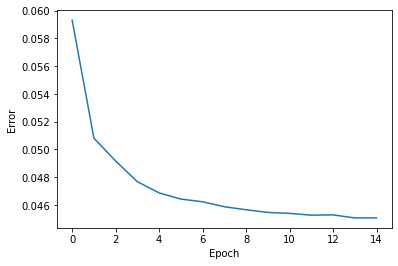

In [16]:
epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<a id="ref5"></a>
<h2>Recommendation</h2>

Kita dapat memprediksi film yang mungkin disukai oleh user yang dipilih secara sesuka hati. Ini dapat dicapai dengan memasukkan preferensi film yang ditonton user ke dalam RBM dan kemudian merekonstruksi inputnya. Nilai yang diberikan RBM akan mencoba memperkirakan preferensi pengguna untuk film yang belum dia tonton berdasarkan preferensi user di tempat RBM dilatih.

Pertama kita pilih dulu <b>User ID</b> dari data yang sudah ada:

In [17]:
mock_user_id = 215

In [18]:
#Memilih input user
inputUser = trX[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0.8, 0. , 0. , ..., 0. , 0. , 0. ]])

In [19]:
#Feeding user and rekonstruksi input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print(rec)

[[0.37440214 0.09113631 0.0053114  ... 0.00244212 0.00224119 0.01059559]]


Kemudian kita dapat membuat list 20 film paling direkomendasikan untuk pengguna ini dengan menyortirnya berdasarkan skor mereka yang diberikan oleh model yang sudah dibuat.

In [20]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.999921
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.993852
2502,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.945660
585,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.931111
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.906568
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.825844
1250,1270,Back to the Future (1985),Comedy|Sci-Fi,0.822235
476,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.812243
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.779732
1539,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.734749


Jadi, bagaimana cara merekomendasikan film yang belum ditonton oleh pengguna?

Sekarang, kita dapat menemukan semua film yang pernah ditonton oleh pengguna tersebut:

In [21]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]
movies_df_mock.head()

,UserID,MovieID,Rating,Timestamp
31603,215,3793,5,977099259
31604,215,1,4,979174987
31605,215,1197,5,976899663
31606,215,2302,5,976899718
31607,215,2167,5,976899770


Di cell berikutnya, kita gabungkan semua film yang telah ditonton pengguna tersebut dengan skor yang diprediksi berdasarkan data historisnya:

In [22]:
#Gabungkan movies_df dengan ratings_df berdasarkan MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

Yuk kita urutkan dan kita lihat 20 baris teratas:

In [23]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.999921,215.0,5.0,976899190.0
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.993852,NaN,NaN,NaN
2374,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.945660,NaN,NaN,NaN
575,589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.931111,NaN,NaN,NaN
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.906568,215.0,5.0,976899689.0
1148,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.825844,NaN,NaN,NaN
1178,1270,Back to the Future (1985),Comedy|Sci-Fi,0.822235,NaN,NaN,NaN
466,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.812243,215.0,5.0,976899784.0
2426,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi,0.779732,215.0,5.0,976908635.0
1449,1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.734749,NaN,NaN,NaN


Seperti yang bisa kita lihat, ada beberapa film yang belum ditonton pengguna dan memiliki skor tinggi berdasarkan model yang sudah dibuat. Jadi, kita dapat merekomendasikannya kepada user.